# Run Velocyto

### Load libraries

In [2]:
%pylab inline

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

## 10X data - colon

Load data

In [134]:
velo_10x = vcy.VelocytoLoom("saved_data/10X/velocyto_10X_merged.loom")
metadata_10x = pd.read_csv("saved_data/10X/metadata_all_data_cl.csv", index_col = 0, header = 0)

lv_colon = pd.read_csv("plots/10X/BGPLVM/latent_variables_colon_mLN_Treg_hvg.csv", index_col = 0, header = 0)

Plot fractions as QC

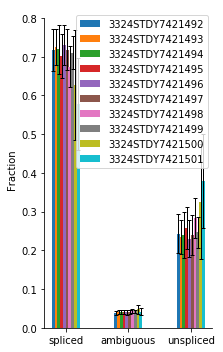

In [135]:
velo_10x.plot_fractions()

Corrrect Cell IDs and filter out those removed in QC

In [136]:
x = []
for cell in range(0, len(velo_10x.ca["CellID"])):
    x.append(velo_10x.ca["CellID"][cell].replace(":", "_").replace("x", "-1"))
velo_10x.ca["CellID"] = np.array(x)

In [137]:
xxx = np.array([x in np.asarray(lv_colon[["cell"]]) for x in velo_10x.ca["CellID"]])
velo_10x.filter_cells(bool_array = xxx)

In [138]:
colors_dict = {'Treg_LTlike': np.array([ 0.4,  0.6431373,  1]), 'Treg_NLT': np.array([ 0.81960784,  0.04705882,  0]), 'Treg_NLTlike': np.array([ 0.9490196,  0.4627451,  0.4627451]),
              'Treg_Stat1': np.array([ 0.2705882,  0.3372549,  0.5019608]), 'Treg_effector': np.array([ 0.6627451,  0.4196078,  0.8078431]), 'Treg_lymphoid': np.array([ 0.1294118,  0.4901961 ,  1]),
              'Treg_suppressive': np.array([ 0.9764706,  0.4705882 ,  0])}
velo_10x.set_clusters(metadata_10x.loc[velo_10x.ca["CellID"]]["cl_annot"], cluster_colors_dict=colors_dict)

Gene Filter

In [139]:
velo_10x.score_detection_levels(min_expr_counts=20, min_cells_express=5,
                           min_expr_counts_U=0, min_cells_express_U=0)
velo_10x.filter_genes(by_detection_levels=True)
velo_10x.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=20, min_cells_express_U=5)
velo_10x.filter_genes(by_detection_levels=True)

Add BGPLVM coordinates

In [140]:
velo_10x.ts = np.column_stack([lv_colon.loc[velo_10x.ca["CellID"]]["LV0"], 
                               lv_colon.loc[velo_10x.ca["CellID"]]["LV2"]])

Normalisation

In [141]:
# best with sample and expression scaling
velo_10x._normalize_S(relative_size=velo_10x.initial_cell_size,
                      target_size=np.mean(velo_10x.initial_cell_size))
velo_10x._normalize_U(relative_size=velo_10x.initial_Ucell_size,
                      target_size=np.mean(velo_10x.initial_Ucell_size))

kNN Imputation

In [142]:
velo_10x.perform_PCA()
k = 50
velo_10x.knn_imputation(n_pca_dims=25, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

Velocyto calculations

In [143]:
velo_10x.fit_gammas(limit_gamma=False, fit_offset=False)
velo_10x.predict_U()
velo_10x.calculate_velocity()
velo_10x.calculate_shift(assumption="constant_velocity")
velo_10x.extrapolate_cell_at_t(delta_t=1.)

Plot some genes

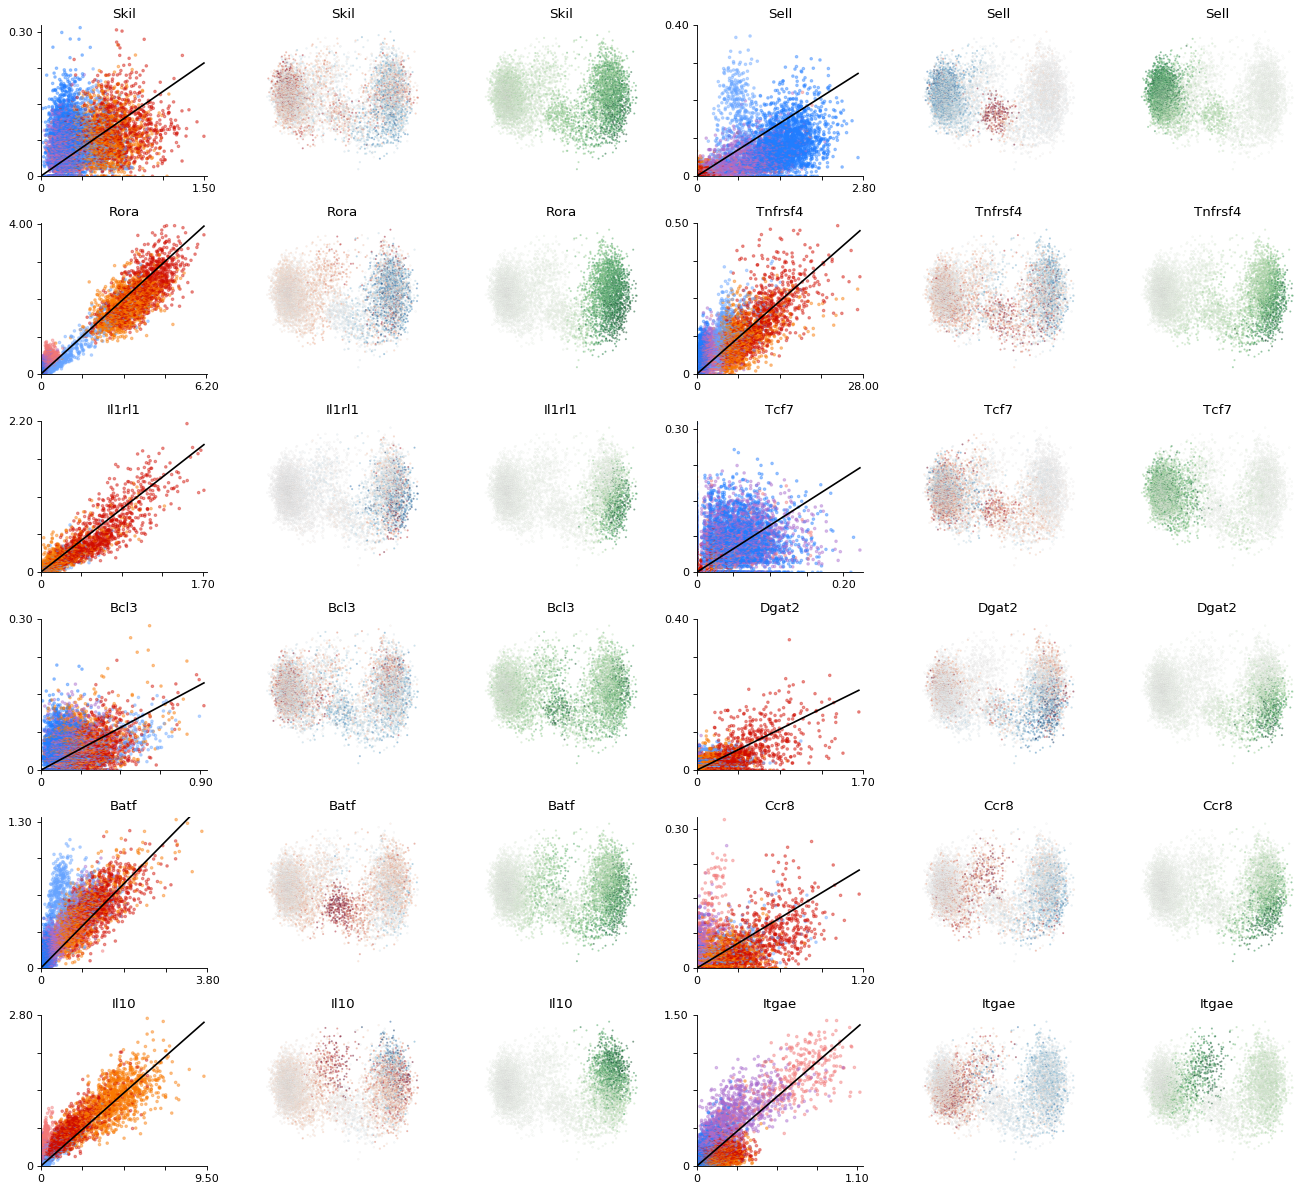

In [144]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Skil", "Sell", "Rora","Tnfrsf4", 'Il1rl1',
                        "Tcf7", "Bcl3", "Dgat2", "Batf", "Ccr8", "Il10", "Itgae"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(velo_10x.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(velo_10x.Sx_sz[ix,:], velo_10x.Ux_sz[ix,:], c=velo_10x.colorandum,
                    s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,velo_10x.Sx[ix,:].max())
    plt.plot(xnew, velo_10x.gammas[ix] * xnew + velo_10x.q[ix], c="k")
    plt.ylim(0, np.max(velo_10x.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(velo_10x.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(velo_10x.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(velo_10x.Sx_sz[ix,:])*1.02)
    despline()
    
    velo_10x.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    velo_10x.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

Calculate transitions

In [145]:
velo_10x.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                  n_neighbors=200, knn_random=True, sampled_fraction=0.5)

In [151]:
velo_10x.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
velo_10x.calculate_grid_arrows(smooth=1, steps=(40, 40), n_neighbors=5)

Plot all arrows

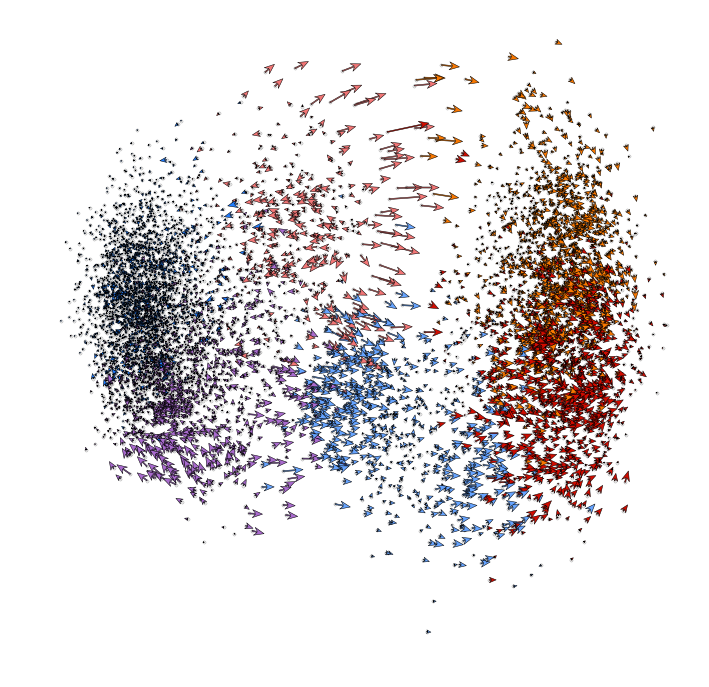

In [152]:
plt.figure(None,(12,12))
quiver_scale = 10

plt.scatter(velo_10x.embedding[:, 0], velo_10x.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(velo_10x.embedding.shape[0], size=int(velo_10x.embedding.shape[0]/1.), replace=False)
plt.scatter(velo_10x.embedding[ix_choice, 0], velo_10x.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=10, headwidth=8,linewidths=0.5, 
                   width=0.0015,edgecolors="k", color=velo_10x.colorandum[ix_choice],
                   alpha=1)
plt.quiver(velo_10x.embedding[ix_choice, 0], velo_10x.embedding[ix_choice, 1],
           velo_10x.delta_embedding[ix_choice, 0], velo_10x.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_10Xcolon.pdf")

Average in region

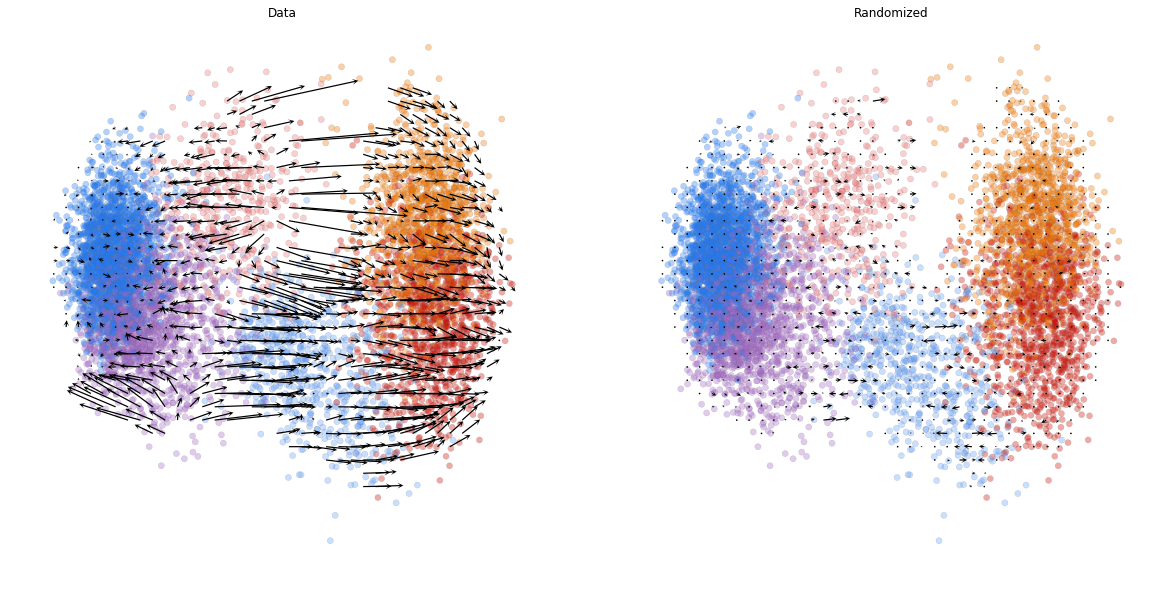

In [153]:
plt.figure(None,(20,10))
velo_10x.plot_grid_arrows(quiver_scale=0.48, 
                          scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", 
                                               "s":38, "rasterized":True}, 
                          min_mass=10, angles='xy', scale_units='xy', headaxislength=2.75, 
                          headlength=5, headwidth=4.8, minlength=1.5, plot_random=True, scale_type="absolute")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_10Xcolon_mean.pdf")

## 10X data - skin

Load data

In [154]:
velo_10x_s = vcy.VelocytoLoom("saved_data/10X/velocyto_10X_merged.loom")
metadata_10x = pd.read_csv("saved_data/10X/metadata_all_data_cl.csv", index_col = 0, header = 0)
lv_skin = pd.read_csv("plots/10X/BGPLVM/latent_variables_skin_bLN_colongenes.csv", index_col = 0, header = 0)

Corrrect Cell IDs and filter out those removed in QC

In [155]:
x = []
for cell in range(0, len(velo_10x_s.ca["CellID"])):
    x.append(velo_10x_s.ca["CellID"][cell].replace(":", "_").replace("x", "-1"))
velo_10x_s.ca["CellID"] = np.array(x)

In [156]:
xxx = np.array([x in np.asarray(lv_skin[["cell"]]) for x in velo_10x_s.ca["CellID"]])
velo_10x_s.filter_cells(bool_array = xxx)

In [157]:
colors_dict = {'Treg_LTlike': np.array([ 0.4,  0.6431373,  1]), 'Treg_NLT': np.array([ 0.81960784,  0.04705882,  0]), 'Treg_NLTlike': np.array([ 0.9490196,  0.4627451,  0.4627451]),
              'Treg_Stat1': np.array([ 0.2705882,  0.3372549,  0.5019608]), 'Treg_effector': np.array([ 0.6627451,  0.4196078,  0.8078431]), 'Treg_lymphoid': np.array([ 0.1294118,  0.4901961 ,  1]),
              'Treg_suppressive': np.array([ 0.9764706,  0.4705882 ,  0])}
velo_10x_s.set_clusters(metadata_10x.loc[velo_10x_s.ca["CellID"]]["cl_annot"], cluster_colors_dict=colors_dict)

Gene filter

In [158]:
velo_10x_s.score_detection_levels(min_expr_counts=20, min_cells_express=5,
                           min_expr_counts_U=0, min_cells_express_U=0)
velo_10x_s.filter_genes(by_detection_levels=True)
velo_10x_s.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=20, min_cells_express_U=5)
velo_10x_s.filter_genes(by_detection_levels=True)

Add BGPLVM coordinates

In [159]:
velo_10x_s.ts = np.column_stack([lv_skin.loc[velo_10x_s.ca["CellID"]]["LV0"], 
                               lv_skin.loc[velo_10x_s.ca["CellID"]]["LV2"]])

Normalisation

In [160]:
# best with sample and expression scaling
velo_10x_s._normalize_S(relative_size=velo_10x_s.initial_cell_size,
                      target_size=np.mean(velo_10x_s.initial_cell_size))
velo_10x_s._normalize_U(relative_size=velo_10x_s.initial_Ucell_size,
                      target_size=np.mean(velo_10x_s.initial_Ucell_size))

kNN imputation

In [161]:
velo_10x_s.perform_PCA()
k = 5
velo_10x_s.knn_imputation(n_pca_dims=25, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

Velocyto calculations

In [162]:
velo_10x_s.fit_gammas(limit_gamma=False, fit_offset=False, use_imputed_data=False)
velo_10x_s.predict_U()
velo_10x_s.calculate_velocity()
velo_10x_s.calculate_shift(assumption="constant_velocity")
velo_10x_s.extrapolate_cell_at_t(delta_t=1.)

Plot some genes

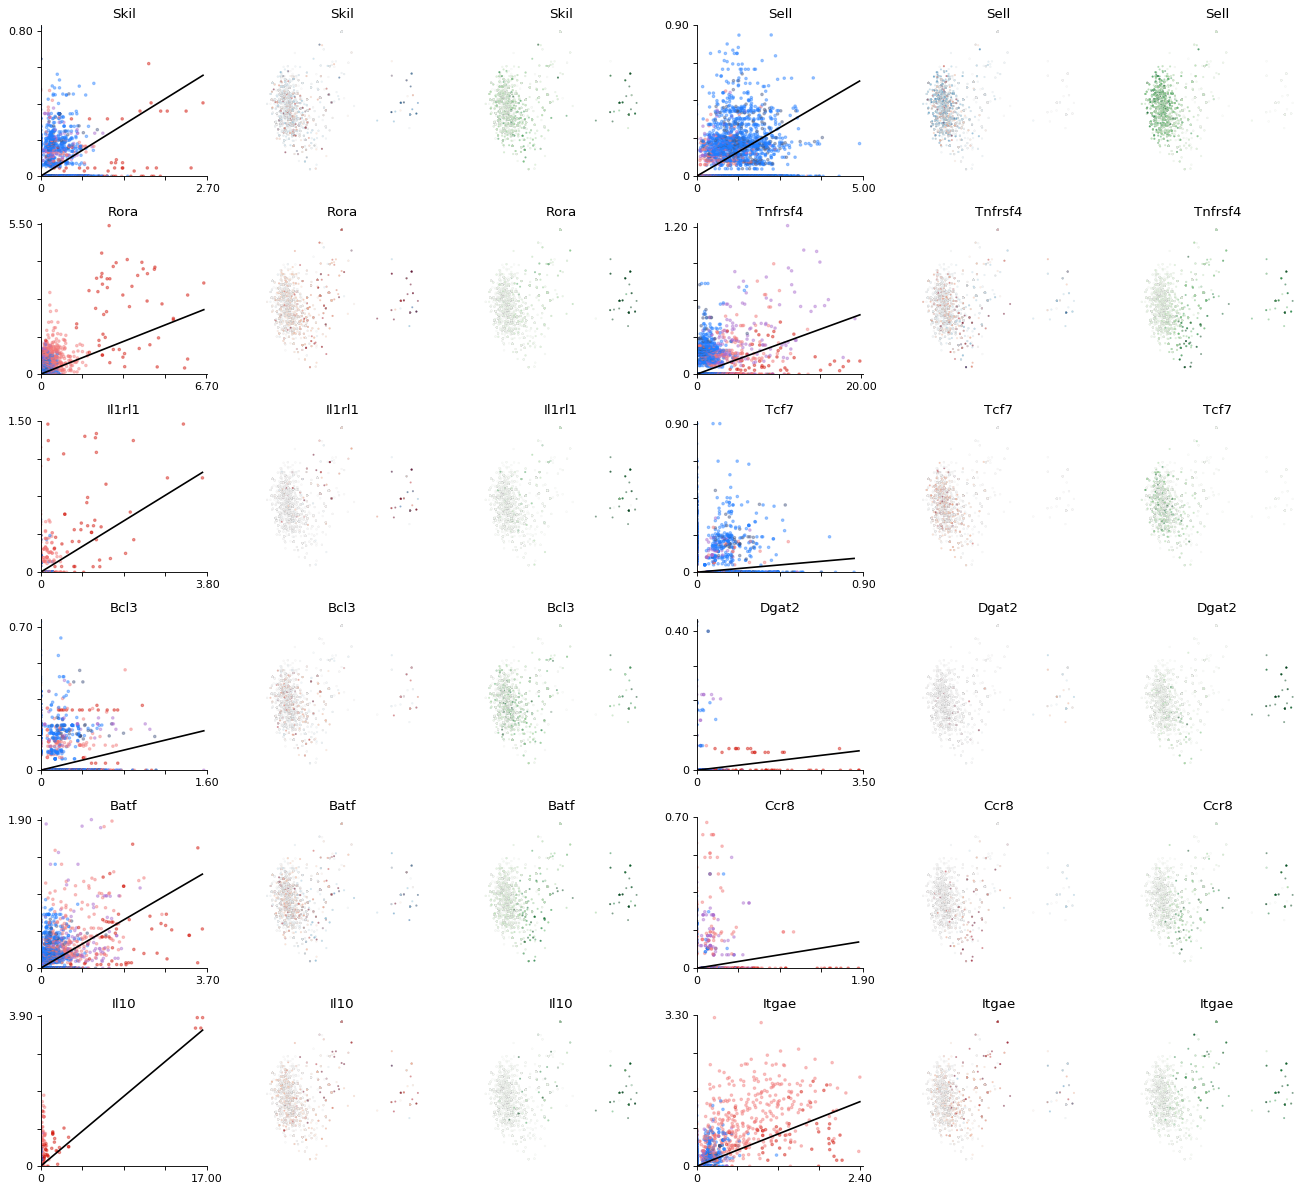

In [163]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Skil", "Sell", "Rora","Tnfrsf4", 'Il1rl1',
                        "Tcf7", "Bcl3", "Dgat2", "Batf", "Ccr8", "Il10", "Itgae"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(velo_10x_s.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(velo_10x_s.Sx_sz[ix,:], velo_10x_s.Ux_sz[ix,:], c=velo_10x_s.colorandum,
                    s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,velo_10x_s.Sx[ix,:].max())
    plt.plot(xnew, velo_10x_s.gammas[ix] * xnew + velo_10x_s.q[ix], c="k")
    plt.ylim(0, np.max(velo_10x_s.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(velo_10x_s.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(velo_10x_s.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(velo_10x_s.Sx_sz[ix,:])*1.02)
    despline()
    
    velo_10x_s.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    velo_10x_s.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

Calculate transitions

In [189]:
velo_10x_s.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                  n_neighbors=50, knn_random=True, sampled_fraction=0.9)

In [190]:
velo_10x_s.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
velo_10x_s.calculate_grid_arrows(smooth=1, steps=(25, 25), n_neighbors=10)

/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Plot all arrows

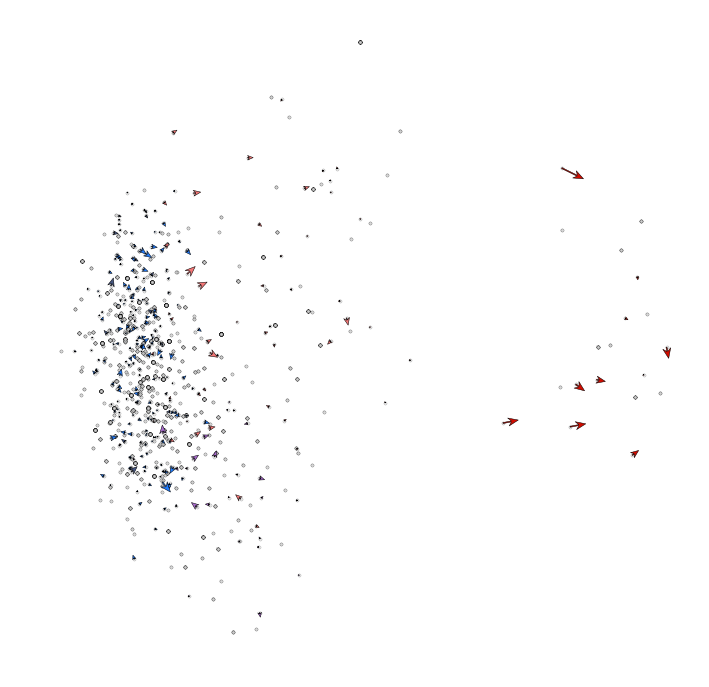

In [191]:
plt.figure(None,(12,12))
quiver_scale = 10

plt.scatter(velo_10x_s.embedding[:, 0], velo_10x_s.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(velo_10x_s.embedding.shape[0], 
                             size=int(velo_10x_s.embedding.shape[0]/1.), replace=False)
plt.scatter(velo_10x_s.embedding[ix_choice, 0], velo_10x_s.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=10, headwidth=8,linewidths=0.5, 
                   width=0.0015,edgecolors="k", color=velo_10x_s.colorandum[ix_choice],
                   alpha=1)
plt.quiver(velo_10x_s.embedding[ix_choice, 0], velo_10x_s.embedding[ix_choice, 1],
           velo_10x_s.delta_embedding[ix_choice, 0], velo_10x_s.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_10Xskin.pdf")

Average in region

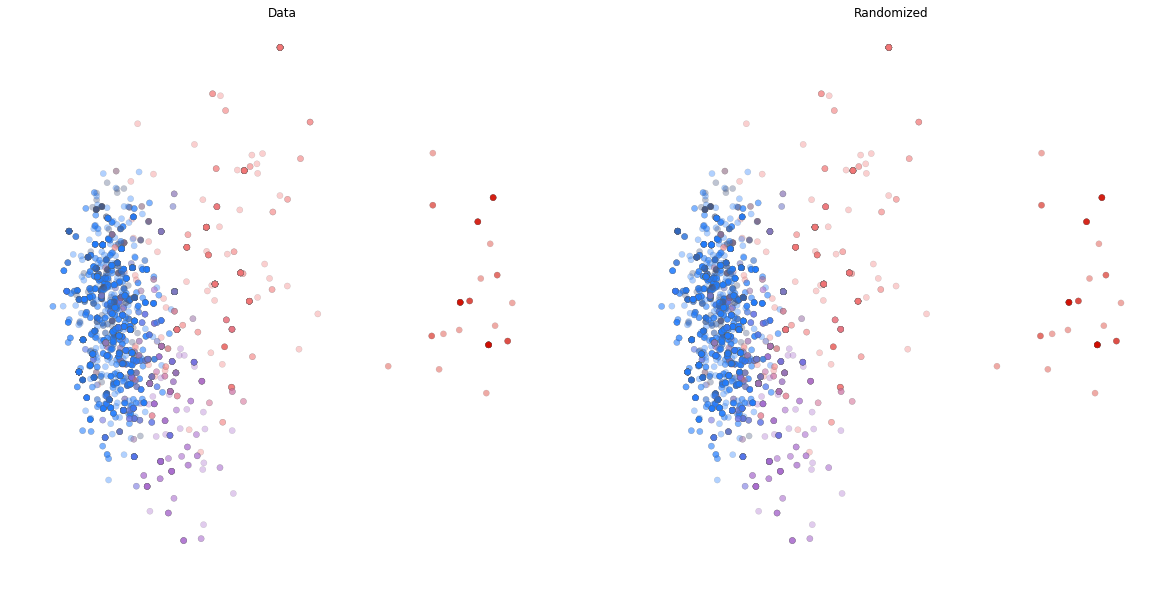

In [192]:
plt.figure(None,(20,10))
velo_10x_s.plot_grid_arrows(quiver_scale=0.48, 
                          scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", 
                                               "s":38, "rasterized":True}, 
                          min_mass=20, angles='xy', scale_units='xy', headaxislength=2.75, 
                          headlength=5, headwidth=4.8, minlength=1.5, plot_random=True, scale_type="absolute")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_10Xskin_mean.pdf")

## SS2 - colon

In [208]:
velo_ss2_c = vcy.VelocytoLoom("saved_data/SS2/onefilepercell_17805_#10_and_others_IXAOM.loom")
metadata_ss2 = pd.read_csv("saved_data/SS2/metadata_mouse_colon.csv", index_col = 0, header = 0)

lv_colon = pd.read_csv("plots/SS2/BGPLVM/latent_variables_colon_mLN_Treg_hvg.csv", index_col = 0, header = 0)

Plot fractions as QC

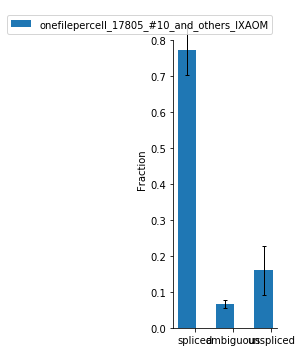

In [209]:
velo_ss2_c.plot_fractions()

Corrrect Cell IDs and filter out those removed in QC

In [210]:
x = []
for cell in range(0, len(velo_ss2_c.ca["CellID"])):
    x.append(velo_ss2_c.ca["CellID"][cell].split(":")[1].split(".")[0].replace("_#", "_cell").replace("#", "_cell"))
velo_ss2_c.ca["CellID"] = np.array(x)

In [211]:
xxx = np.array([x in np.asarray(lv_colon[["cell"]]) for x in velo_ss2_c.ca["CellID"]])
velo_ss2_c.filter_cells(bool_array = xxx)

In [212]:
colors_dict = {'LN.Treg': np.array([ 0.1294118,  0.4901961 ,  1]), 'colon.Treg': np.array([ 0.81960784,  0.04705882,  0])}
velo_ss2_c.set_clusters(metadata_ss2.loc[velo_ss2_c.ca["CellID"]]["tissue_cell"], cluster_colors_dict=colors_dict)

Gene filter

In [213]:
velo_ss2_c.score_detection_levels(min_expr_counts=10, min_cells_express=3,
                                  min_expr_counts_U=0, min_cells_express_U=0)
velo_ss2_c.filter_genes(by_detection_levels=True)
velo_ss2_c.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                                  min_expr_counts_U=10, min_cells_express_U=3)
velo_ss2_c.filter_genes(by_detection_levels=True)

Add BGPLVM coordinates

In [214]:
velo_ss2_c.ts = np.column_stack([lv_colon.loc[velo_ss2_c.ca["CellID"]]["LV0"], 
                                 lv_colon.loc[velo_ss2_c.ca["CellID"]]["LV5"]])

Normalisation

In [215]:
# best with sample and expression scaling
velo_ss2_c._normalize_S(relative_size=velo_ss2_c.initial_cell_size,
                      target_size=np.mean(velo_ss2_c.initial_cell_size))
velo_ss2_c._normalize_U(relative_size=velo_ss2_c.initial_Ucell_size,
                      target_size=np.mean(velo_ss2_c.initial_Ucell_size))

kNN imputation

In [216]:
velo_ss2_c.perform_PCA()
k = 5
velo_ss2_c.knn_imputation(n_pca_dims=25, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

Velocyto calculations

In [217]:
velo_ss2_c.fit_gammas(limit_gamma=False, fit_offset=False, use_imputed_data=False)
velo_ss2_c.predict_U()
velo_ss2_c.calculate_velocity()
velo_ss2_c.calculate_shift(assumption="constant_velocity")
velo_ss2_c.extrapolate_cell_at_t(delta_t=1.)

Plot some genes

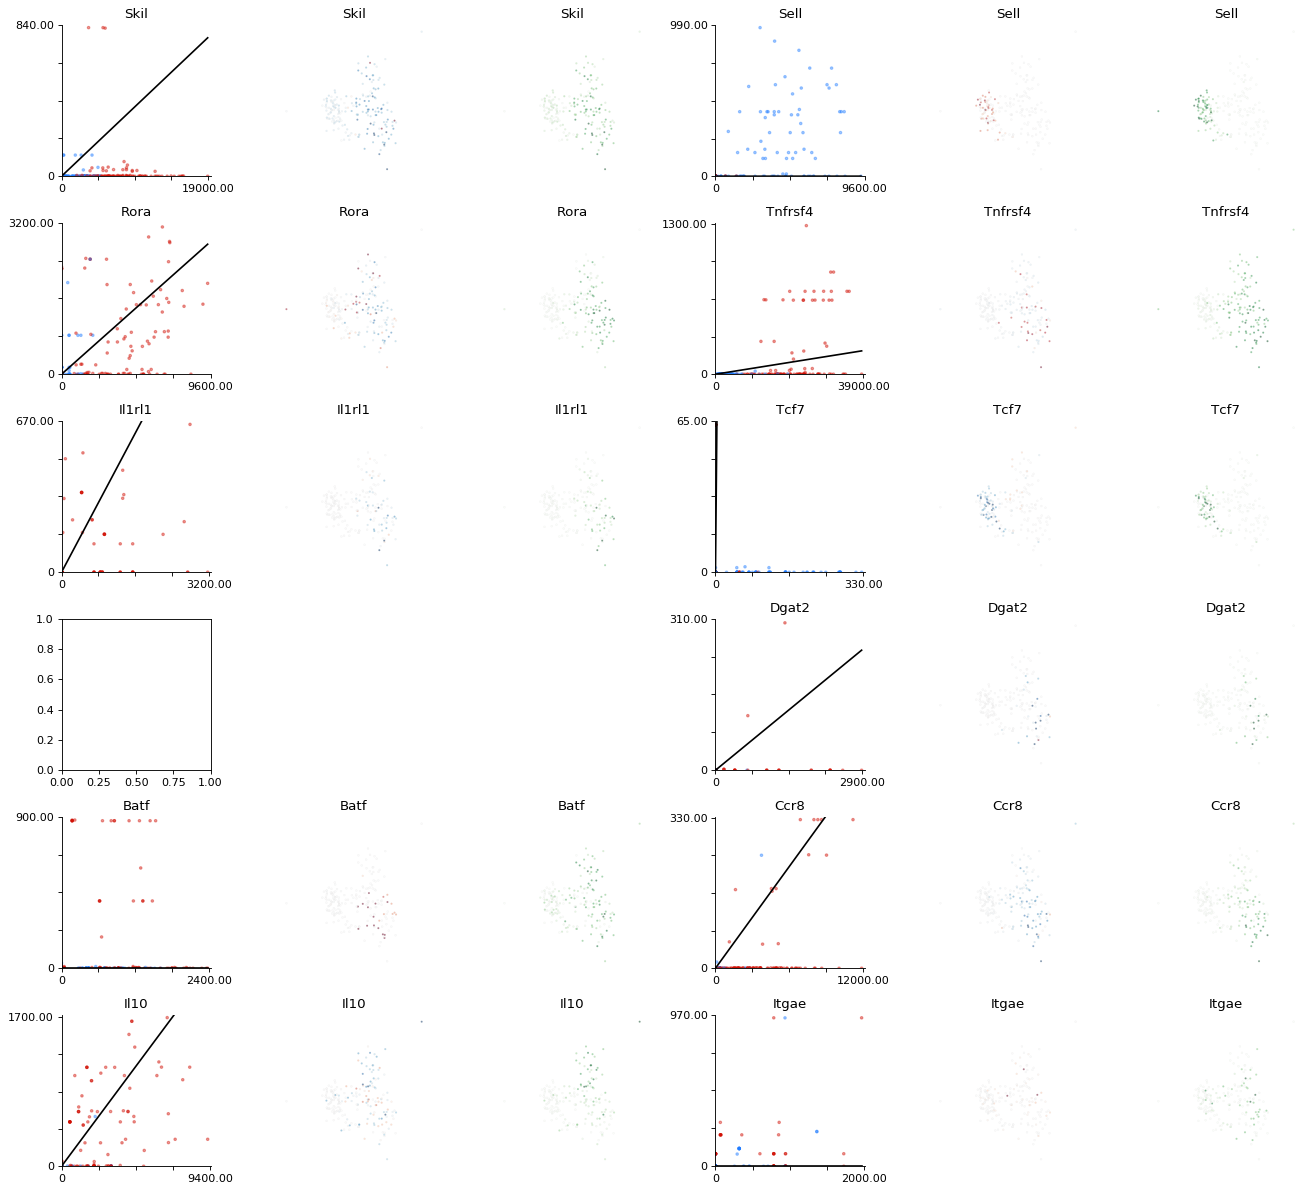

In [218]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Skil", "Sell", "Rora","Tnfrsf4", 'Il1rl1',
                        "Tcf7", "Bcl3", "Dgat2", "Batf", "Ccr8", "Il10", "Itgae"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(velo_ss2_c.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(velo_ss2_c.Sx_sz[ix,:], velo_ss2_c.Ux_sz[ix,:], c=velo_ss2_c.colorandum,
                    s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,velo_ss2_c.Sx[ix,:].max())
    plt.plot(xnew, velo_ss2_c.gammas[ix] * xnew + velo_ss2_c.q[ix], c="k")
    plt.ylim(0, np.max(velo_ss2_c.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(velo_ss2_c.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(velo_ss2_c.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(velo_ss2_c.Sx_sz[ix,:])*1.02)
    despline()
    
    velo_ss2_c.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    velo_ss2_c.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

Calculate transitions

In [238]:
velo_ss2_c.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                    n_neighbors=50, knn_random=False, sampled_fraction=1)

In [245]:
velo_ss2_c.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
velo_ss2_c.calculate_grid_arrows(smooth=1, steps=(25, 25), n_neighbors=50)

Plot all arrows

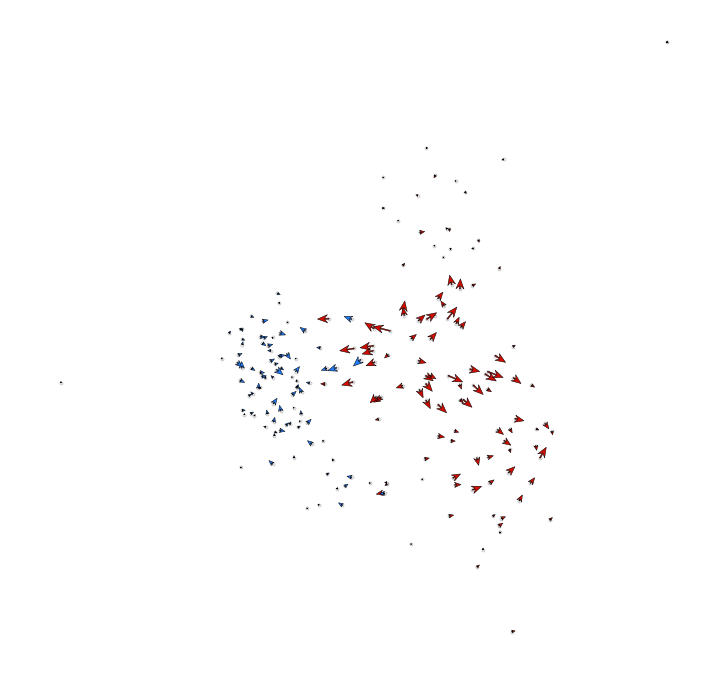

In [246]:
plt.figure(None,(12,12))
quiver_scale = 10

plt.scatter(velo_ss2_c.embedding[:, 0], velo_ss2_c.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(velo_ss2_c.embedding.shape[0], 
                             size=int(velo_ss2_c.embedding.shape[0]/1.), replace=False)
plt.scatter(velo_ss2_c.embedding[ix_choice, 0], velo_ss2_c.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=10, headwidth=8,linewidths=0.5, 
                   width=0.0015,edgecolors="k", color=velo_ss2_c.colorandum[ix_choice],
                   alpha=1)
plt.quiver(velo_ss2_c.embedding[ix_choice, 0], velo_ss2_c.embedding[ix_choice, 1],
           velo_ss2_c.delta_embedding[ix_choice, 0], velo_ss2_c.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_SS2colon.pdf")

Average in region

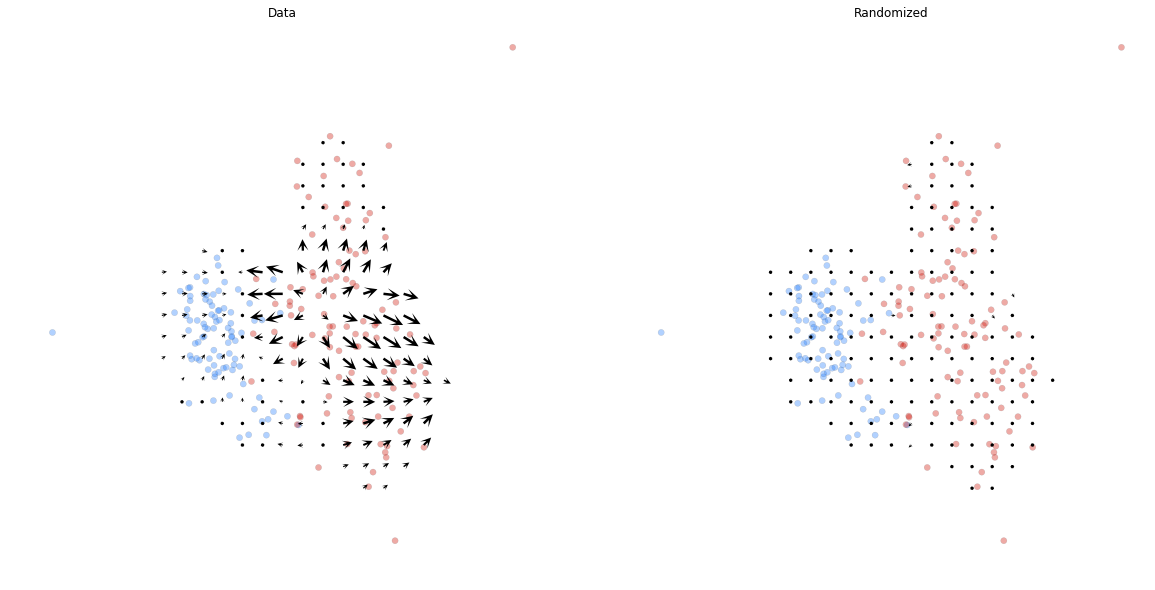

In [247]:
plt.figure(None,(20,10))
velo_ss2_c.plot_grid_arrows(quiver_scale=0.48, 
                          scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", 
                                               "s":38, "rasterized":True}, 
                          min_mass=3, angles='xy', scale_units='xy', headaxislength=2.75, 
                          headlength=5, headwidth=4.8, minlength=1.5, plot_random=True, scale_type="absolute")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_SS2colon_mean.pdf")

## SS2 - skin

In [248]:
velo_ss2_s = vcy.VelocytoLoom("saved_data/SS2/onefilepercell_17805_#10_and_others_IXAOM.loom")
metadata_ss2 = pd.read_csv("saved_data/SS2/metadata_mouse_skin.csv", index_col = 0, header = 0)

lv_skin = pd.read_csv("plots/SS2/BGPLVM/latent_variables_skin_bLN_Treg_hvg.csv", index_col = 0, header = 0)

Corrrect Cell IDs and filter out those removed in QC

In [249]:
x = []
for cell in range(0, len(velo_ss2_s.ca["CellID"])):
    x.append(velo_ss2_s.ca["CellID"][cell].split(":")[1].split(".")[0].replace("_#", "_cell").replace("#", "_cell"))
velo_ss2_s.ca["CellID"] = np.array(x)

In [250]:
xxx = np.array([x in np.asarray(lv_skin[["cell"]]) for x in velo_ss2_s.ca["CellID"]])
velo_ss2_s.filter_cells(bool_array = xxx)

In [251]:
colors_dict = {'LN.Treg': np.array([ 0.1294118,  0.4901961 ,  1]), 'skin.Treg': np.array([ 0.81960784,  0.04705882,  0])}
velo_ss2_s.set_clusters(metadata_ss2.loc[velo_ss2_s.ca["CellID"]]["tissue_cell"], cluster_colors_dict=colors_dict)

Gene filter

In [252]:
velo_ss2_s.score_detection_levels(min_expr_counts=10, min_cells_express=3,
                                  min_expr_counts_U=0, min_cells_express_U=0)
velo_ss2_s.filter_genes(by_detection_levels=True)
velo_ss2_s.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                                  min_expr_counts_U=10, min_cells_express_U=3)
velo_ss2_s.filter_genes(by_detection_levels=True)

Add BGPLVM coordinates

In [253]:
velo_ss2_s.ts = np.column_stack([lv_skin.loc[velo_ss2_s.ca["CellID"]]["LV0"], 
                                 lv_skin.loc[velo_ss2_s.ca["CellID"]]["LV5"]])

Normalisation

In [254]:
# best with sample and expression scaling
velo_ss2_s._normalize_S(relative_size=velo_ss2_s.initial_cell_size,
                      target_size=np.mean(velo_ss2_s.initial_cell_size))
velo_ss2_s._normalize_U(relative_size=velo_ss2_s.initial_Ucell_size,
                      target_size=np.mean(velo_ss2_s.initial_Ucell_size))

kNN imputation

In [255]:
velo_ss2_s.perform_PCA()
k = 5
velo_ss2_s.knn_imputation(n_pca_dims=25, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

Velocyto calculations

In [256]:
velo_ss2_s.fit_gammas(limit_gamma=False, fit_offset=False, use_imputed_data=False)
velo_ss2_s.predict_U()
velo_ss2_s.calculate_velocity()
velo_ss2_s.calculate_shift(assumption="constant_velocity")
velo_ss2_s.extrapolate_cell_at_t(delta_t=1.)

Plot some genes

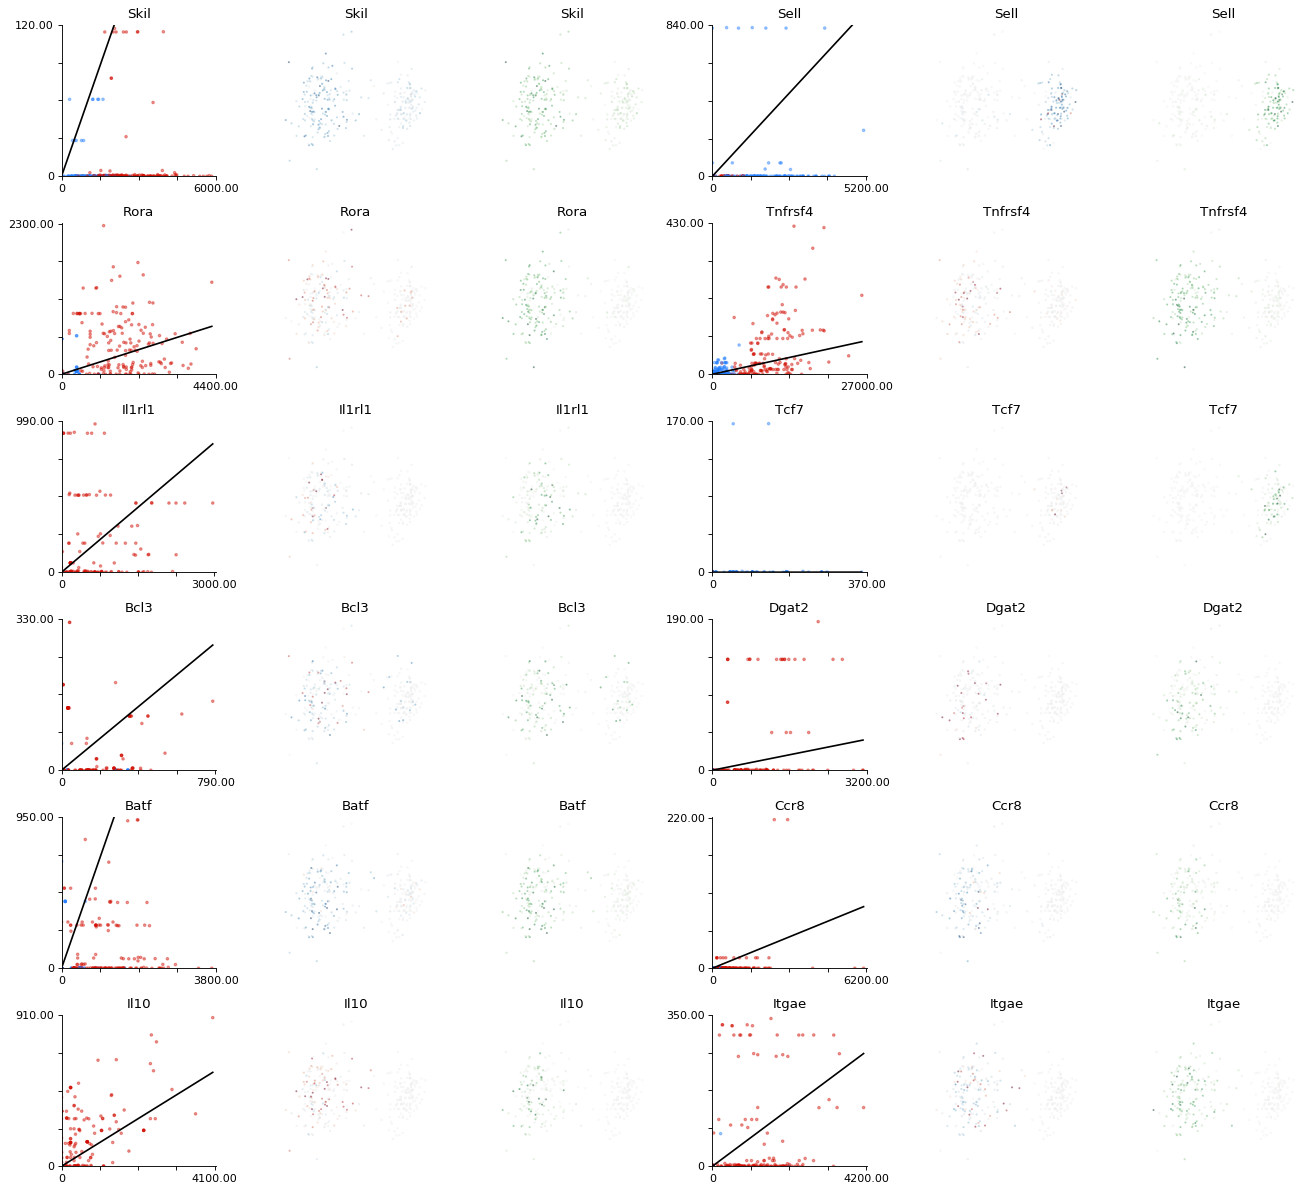

In [257]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Skil", "Sell", "Rora","Tnfrsf4", 'Il1rl1',
                        "Tcf7", "Bcl3", "Dgat2", "Batf", "Ccr8", "Il10", "Itgae"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(velo_ss2_s.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(velo_ss2_s.Sx_sz[ix,:], velo_ss2_s.Ux_sz[ix,:], c=velo_ss2_s.colorandum,
                    s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,velo_ss2_s.Sx[ix,:].max())
    plt.plot(xnew, velo_ss2_s.gammas[ix] * xnew + velo_ss2_s.q[ix], c="k")
    plt.ylim(0, np.max(velo_ss2_s.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(velo_ss2_s.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(velo_ss2_s.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(velo_ss2_s.Sx_sz[ix,:])*1.02)
    despline()
    
    velo_ss2_s.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    velo_ss2_s.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

Calculate transitions

In [262]:
velo_ss2_s.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                    n_neighbors=50, knn_random=False, sampled_fraction=1)

In [273]:
velo_ss2_s.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
velo_ss2_s.calculate_grid_arrows(smooth=1, steps=(20, 20), n_neighbors=20)

Plot all arrows

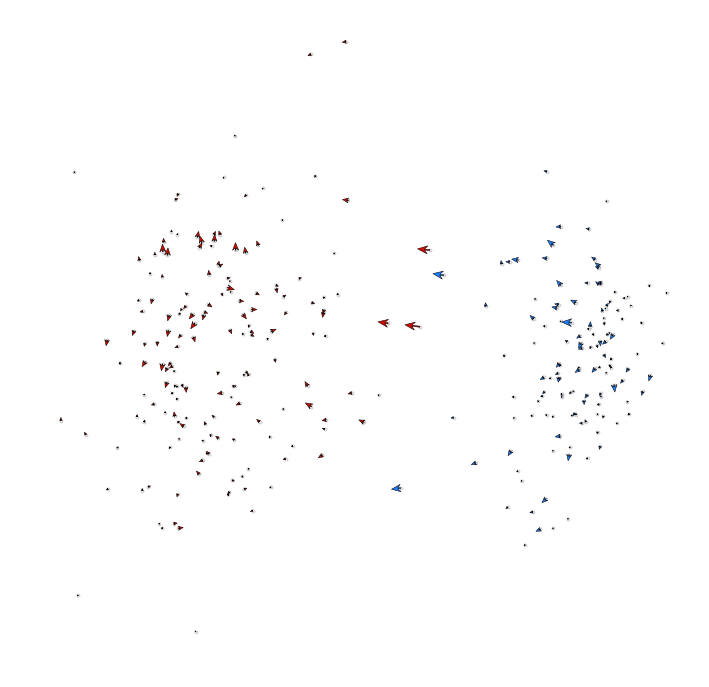

In [274]:
plt.figure(None,(12,12))
quiver_scale = 10

plt.scatter(velo_ss2_s.embedding[:, 0], velo_ss2_s.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(velo_ss2_s.embedding.shape[0], 
                             size=int(velo_ss2_s.embedding.shape[0]/1.), replace=False)
plt.scatter(velo_ss2_s.embedding[ix_choice, 0], velo_ss2_s.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=10, headwidth=8,linewidths=0.5, 
                   width=0.0015,edgecolors="k", color=velo_ss2_s.colorandum[ix_choice],
                   alpha=1)
plt.quiver(velo_ss2_s.embedding[ix_choice, 0], velo_ss2_s.embedding[ix_choice, 1],
           velo_ss2_s.delta_embedding[ix_choice, 0], velo_ss2_s.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_SS2skin.pdf")

Average in region

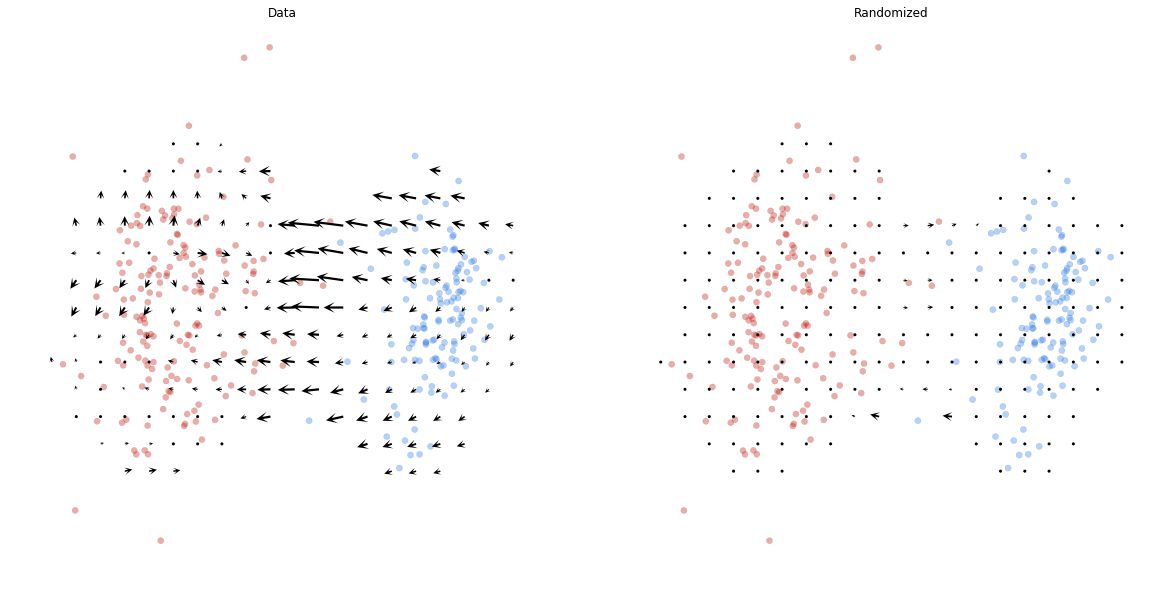

In [275]:
plt.figure(None,(20,10))
velo_ss2_s.plot_grid_arrows(quiver_scale=0.48, 
                          scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", 
                                               "s":38, "rasterized":True}, 
                          min_mass=3, angles='xy', scale_units='xy', headaxislength=2.75, 
                          headlength=5, headwidth=4.8, minlength=1.5, plot_random=True, scale_type="absolute")
plt.savefig("./FINAL_PLOTS/plot_repository/velocyto_SS2skin_mean.pdf")

## SS2 Melanoma

In [102]:
velo_ss2_s = vcy.VelocytoLoom("saved_data/SS2/onefilepercell_17805_#10_and_others_IXAOM.loom")
metadata_ss2 = pd.read_csv("plots/SS2/MRD_melanoma/mouse_mel_metadata.csv", index_col = 0, header = 0)

lv_skin = pd.read_csv("plots/SS2/MRD_melanoma/latent_variables_MRD_LNskinTreg.csv", index_col = 0, header = 0)

Correct Cell IDs and filter out those removed in QC

In [103]:
x = []
for cell in range(0, len(velo_ss2_s.ca["CellID"])):
    x.append(velo_ss2_s.ca["CellID"][cell].split(":")[1].split(".")[0].replace("_#", "_cell").replace("#", "_cell"))
velo_ss2_s.ca["CellID"] = np.array(x)

In [104]:
xxx = np.array([x in np.asarray(lv_skin[["cell"]]) for x in velo_ss2_s.ca["CellID"]])
velo_ss2_s.filter_cells(bool_array = xxx)

In [105]:
colors_dict = {'LN.Treg.Tumour': np.array([ 0.6392157,  0.8941176,  1]), 'skin.Treg.Tumour': np.array([ 0.8980392,  0.6745098 ,  0.6745098]),
               'LN.Treg.Control': np.array([ 0.1568627,  0.7607843,  1]), 'skin.Treg.Control': np.array([ 0.81960784,  0.04705882,  0])}
velo_ss2_s.set_clusters(metadata_ss2.loc[velo_ss2_s.ca["CellID"]]["t_c_cond"], cluster_colors_dict=colors_dict)

Gene filter

In [106]:
velo_ss2_s.score_detection_levels(min_expr_counts=10, min_cells_express=3,
                                  min_expr_counts_U=0, min_cells_express_U=0)
velo_ss2_s.filter_genes(by_detection_levels=True)
velo_ss2_s.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                                  min_expr_counts_U=10, min_cells_express_U=3)
velo_ss2_s.filter_genes(by_detection_levels=True)

Add MRD BGPLVM coordinates

In [107]:
velo_ss2_s.ts = np.column_stack([-lv_skin.loc[velo_ss2_s.ca["CellID"]]["LV9"], 
                                 -lv_skin.loc[velo_ss2_s.ca["CellID"]]["LV5"]])

Normalisation

In [108]:
# best with sample and expression scaling
velo_ss2_s._normalize_S(relative_size=velo_ss2_s.initial_cell_size,
                      target_size=np.mean(velo_ss2_s.initial_cell_size))
velo_ss2_s._normalize_U(relative_size=velo_ss2_s.initial_Ucell_size,
                      target_size=np.mean(velo_ss2_s.initial_Ucell_size))

kNN imputation

In [109]:
velo_ss2_s.perform_PCA()
k = 10
velo_ss2_s.knn_imputation(n_pca_dims=30, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

Velocyto calculations

In [110]:
velo_ss2_s.fit_gammas(limit_gamma=False, fit_offset=False, use_imputed_data=False)
velo_ss2_s.predict_U()
velo_ss2_s.calculate_velocity()
velo_ss2_s.calculate_shift(assumption="constant_velocity")
velo_ss2_s.extrapolate_cell_at_t(delta_t=1.)

Plot some genes

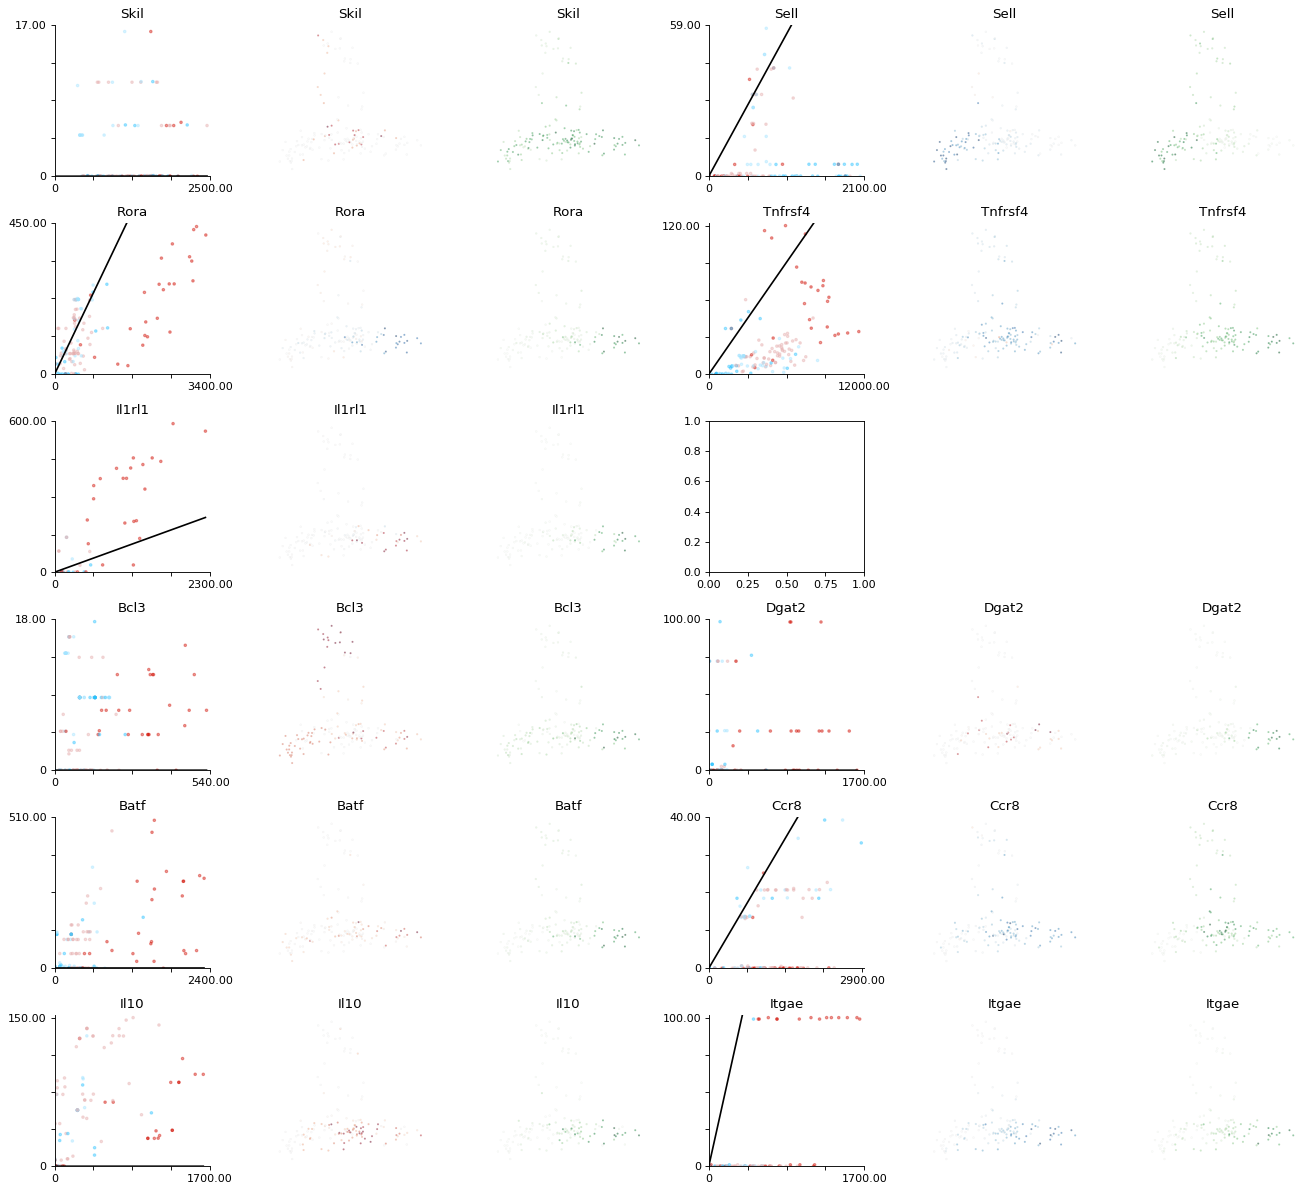

In [111]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Skil", "Sell", "Rora","Tnfrsf4", 'Il1rl1',
                        "Tcf7", "Bcl3", "Dgat2", "Batf", "Ccr8", "Il10", "Itgae"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(velo_ss2_s.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(velo_ss2_s.Sx_sz[ix,:], velo_ss2_s.Ux_sz[ix,:], c=velo_ss2_s.colorandum,
                    s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,velo_ss2_s.Sx[ix,:].max())
    plt.plot(xnew, velo_ss2_s.gammas[ix] * xnew + velo_ss2_s.q[ix], c="k")
    plt.ylim(0, np.max(velo_ss2_s.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(velo_ss2_s.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(velo_ss2_s.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(velo_ss2_s.Sx_sz[ix,:])*1.02)
    despline()
    
    velo_ss2_s.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    velo_ss2_s.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

Calculate transitions

In [112]:
velo_ss2_s.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                                    n_neighbors=30, knn_random=False, sampled_fraction=1)

In [131]:
velo_ss2_s.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
velo_ss2_s.calculate_grid_arrows(smooth=1, steps=(25, 25), n_neighbors=2)

/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Plot all arrows

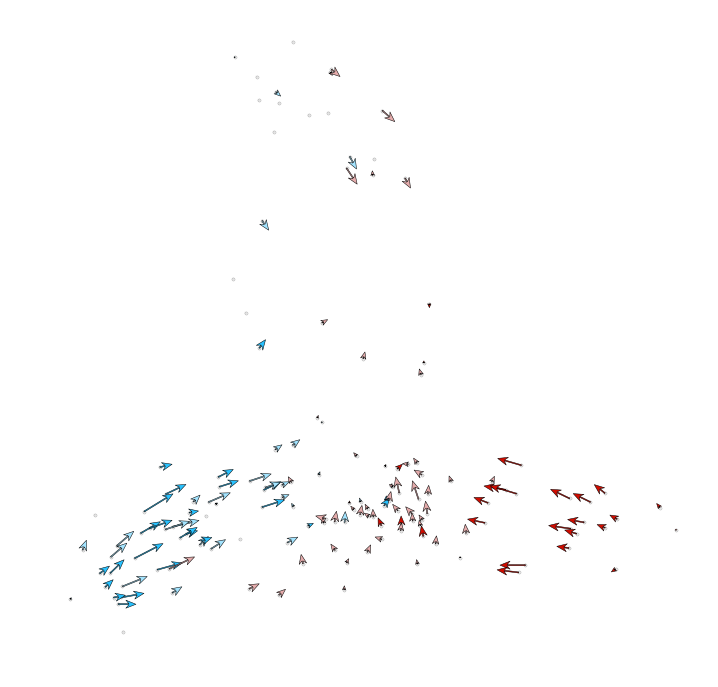

In [132]:
plt.figure(None,(12,12))
quiver_scale = 10

plt.scatter(velo_ss2_s.embedding[:, 0], velo_ss2_s.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(velo_ss2_s.embedding.shape[0], 
                             size=int(velo_ss2_s.embedding.shape[0]/1.), replace=False)
plt.scatter(velo_ss2_s.embedding[ix_choice, 0], velo_ss2_s.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=10, headwidth=8,linewidths=0.5, 
                   width=0.0015,edgecolors="k", color=velo_ss2_s.colorandum[ix_choice],
                   alpha=1)
plt.quiver(velo_ss2_s.embedding[ix_choice, 0], velo_ss2_s.embedding[ix_choice, 1],
           velo_ss2_s.delta_embedding[ix_choice, 0], velo_ss2_s.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("FINAL_PLOTS/plot_repository/velocyto_melanoma.pdf")

Average in region

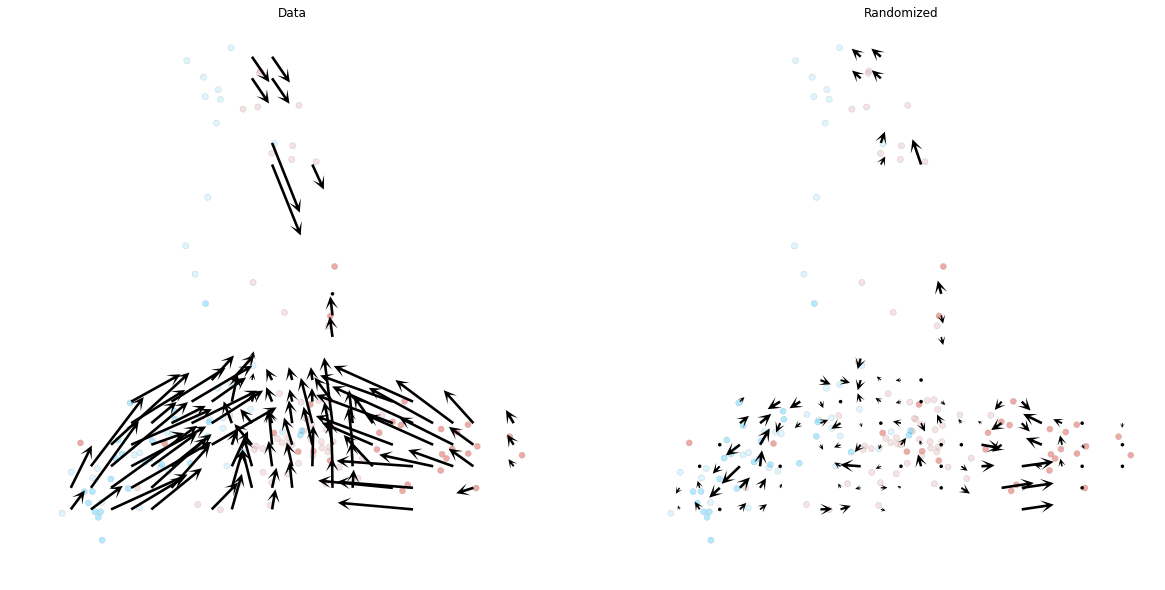

In [133]:
plt.figure(None,(20,10))
velo_ss2_s.plot_grid_arrows(quiver_scale=0.48, 
                          scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", 
                                               "s":38, "rasterized":True}, 
                          min_mass=3, angles='xy', scale_units='xy', headaxislength=2.75, 
                          headlength=5, headwidth=4.8, minlength=1.5, plot_random=True, scale_type="absolute")
plt.savefig("FINAL_PLOTS/plot_repository/velocyto_melanoma_mean.pdf")